## Yum or Yuck Butterfly Mimics 2022 – Explore Dataset

**Author:** [Keith Pinson](https://github.com/keithpinson)<br>
**Date created:** 2022/06/28<br>
**Version:** 1.0.0001<br>
**Description:** Explore the dataset<br>


In [25]:
import datetime

print("executed",datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),"local time")

executed 2022-06-29 11:39:31 local time


## &nbsp;
---
## Set Environment
---

In [26]:
import os
import random

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

import seaborn as sns
import os #path finder

from skimage import io
from skimage.io import imread, imshow, imread_collection, concatenate_images, find_available_plugins
from skimage.color import rgb2gray
import plotly.express as px

### <u>Dataset paths and names</u>

In [27]:
dataset_name = "YOYMimics-2022-dataset"

# We will just set the variables assuming a Windows platform
data_dir = os.path.join('.', dataset_name, 'data', 'butterfly_mimics')
working_dir = os.path.join(os.environ.get("HOMEPATH"), dataset_name)
temp_dir = os.path.join(os.environ.get("TMP"), dataset_name)

train_dir = os.path.join(data_dir, 'images')
test_dir = os.path.join(data_dir, 'image_holdouts')
train_csv = os.path.join(data_dir, 'images.csv')
test_csv = os.path.join(data_dir, 'image_holdouts.csv')
submit_csv = os.path.join('.', 'sample_submission.csv')

# We will create these files from the provided csv files
working_train_csv = os.path.join(working_dir, 'working_images.csv')
working_test_csv = os.path.join(working_dir, "working_image_holdouts.csv")

### <u>Datasets</u>

We will need to use the csv files to make working datasets, that is datasets with a feature tensor and, in the case of training, a label vector.

The *image* field of the csv will be used to lookup the image file of the same name. The image file will become the feature. For the training dataset, the *name* field will be encoded to become the label.

For this notebook, we will not use the *stage* and *side* fields in the training dataset.

In [28]:
train_csv_data = pd.read_csv(train_csv)

In [29]:
test_csv_data = pd.read_csv(test_csv)

In [30]:
train_ds = None

In [31]:
test_ds = None

### &nbsp;
---
### Check our Dataset Environment
---


### First, what does our directory structure look like?
```
.
├── image_holdouts
│   ├── gna250129d.jpg
│   ├── goabc6e644.jpg
│   ├── gpcb27504e.jpg
╎   ╎
│   └── zx54a72a62.jpg
├── images
│   ├── ggc1e08cbc.jpg
│   ├── gh150f104b.jpg
│   ├── gh20ab0d9c.jpg
╎   ╎
│   └── zze50f4f4f.jpg
├── image_holdouts.csv
└── images.csv
```

### &nbsp;
### Let's make our datasets from the CSVs

In [32]:
# Build the training dataset

### &nbsp;
---
### Explore Training Dataset
---


### What do the csv files look like?

In [33]:
print("From the images.csv file:")
print("-------------------------")
train_csv_data.head()

From the images.csv file:
-------------------------


,image,name,stage,side
0,ggc1e08cbc,monarch,adult,ventral
1,gh150f104b,tiger,adult,both
2,gh20ab0d9c,black,adult,dorsal
3,gh2d5c8c79,monarch,adult,dorsal
4,gh6adf74a4,pipevine,adult,dorsal


In [34]:
print("Training Dataset Sample")
print("-----------------------")
train_ds.head()

Training Dataset Sample
-----------------------


AttributeError: 'NoneType' object has no attribute 'head'

### &nbsp;
### What species of butterflies do we have?

In [35]:
print(train_csv_data['name'].unique())

['monarch' 'tiger' 'black' 'pipevine' 'viceroy' 'spicebush']


### &nbsp;
### How many images of each do we have?

In [36]:
print("Total:\t\t", train_csv_data['name'].count())
print("")
print(train_csv_data['name'].value_counts())

Total:		 852

pipevine     192
black        160
tiger        152
monarch      132
viceroy      108
spicebush    108
Name: name, dtype: int64


### &nbsp;
### Let's visualize the count

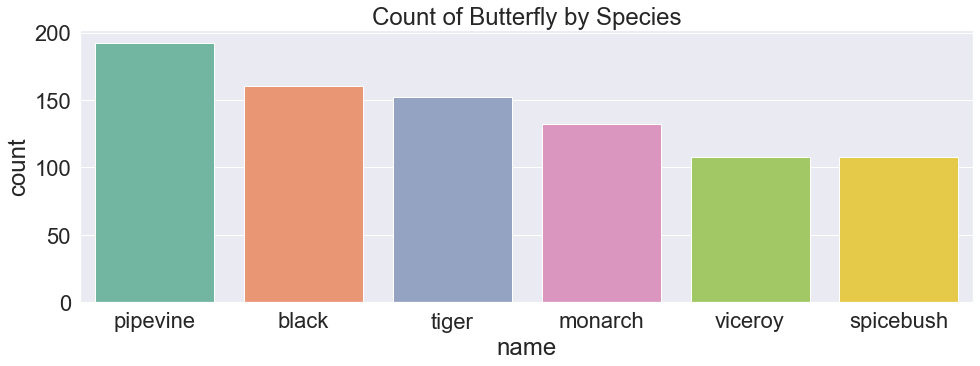

In [37]:
fig = plt.figure(figsize=(16, 5))
sns.set_theme(font_scale=2,palette="Set2")
sns.countplot(x=train_csv_data['name'],
            order=train_csv_data['name'].value_counts().index).set(title='Count of Butterfly by Species')
plt.xticks(rotation=0);

### &nbsp;
### Let's visualize the size of the image data?

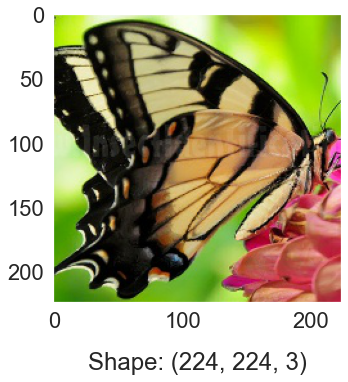

In [38]:
first_file = os.path.join(train_dir, train_csv_data.image[1]+".jpg")

image = io.imread(first_file, as_gray=False)

figure = plt.figure()
ax = figure.add_axes([0, 0, 1, 1])

ax.grid(None)
ax.axis('on')

ax.xaxis.labelpad = 20
ax.xaxis.set_label_text(f'Shape: {image.shape}')
plt.imshow(image,  interpolation_stage='rgb')
plt.show()



### &nbsp;
### What do the images look like?

In [39]:
# Run or re-run this to start at the first image
j = 0

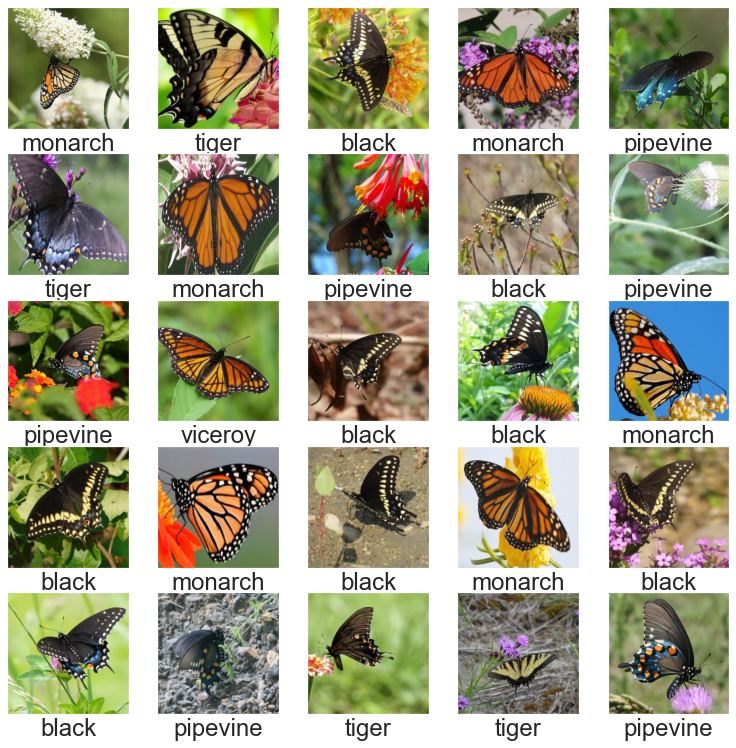

In [40]:
fig, ax = plt.subplots(5, 5, figsize=(13, 13))

maxloop = int(len(train_csv_data)/25)+1

if j < maxloop:
    for i, axi in enumerate(ax.flat):
        k = (j*25) + i

        if k < len(train_csv_data):
            file = os.path.join(train_dir, train_csv_data.image[k]+".jpg")
            image = io.imread(file, as_gray=False)

            axi.grid(None)
            axi.axis('on')

            axi.imshow(image, interpolation_stage='rgb')
            axi.set(xticks=[], yticks=[], xlabel = train_csv_data.name[k])
        else:
            axi.set_visible(False)

    j = j + 1
    plt.show()

###  
### Do we have any missing data?

In [41]:
print("Missing data from the images.csv file:")
print("--------------------------------------")
train_csv_data.isna().sum()

Missing data from the images.csv file:
--------------------------------------


image    0
name     0
stage    0
side     0
dtype: int64

In [42]:
print("Missing data from training dataset:")
print("-----------------------------------")
train_ds.isna().sum()

Missing data from training dataset:
-----------------------------------


AttributeError: 'NoneType' object has no attribute 'isna'

### &nbsp;
---
### Explore Test Dataset
---


### What do the test csv files look like?

In [43]:
print("From the image_holdouts.csv file:")
print("---------------------------------")

test_csv_data.head()

From the image_holdouts.csv file:
---------------------------------


,image
0,gna250129d
1,goabc6e644
2,gpcb27504e
3,gsc64524dc
4,guf6eae7c8


In [44]:
print("Test Dataset Sample")
print("-------------------")
test_ds.head()

Test Dataset Sample
-------------------


AttributeError: 'NoneType' object has no attribute 'head'

### &nbsp;
### What do the test images look like?

In [45]:
# Run and then re-run this cell to start with the first image
j = 0

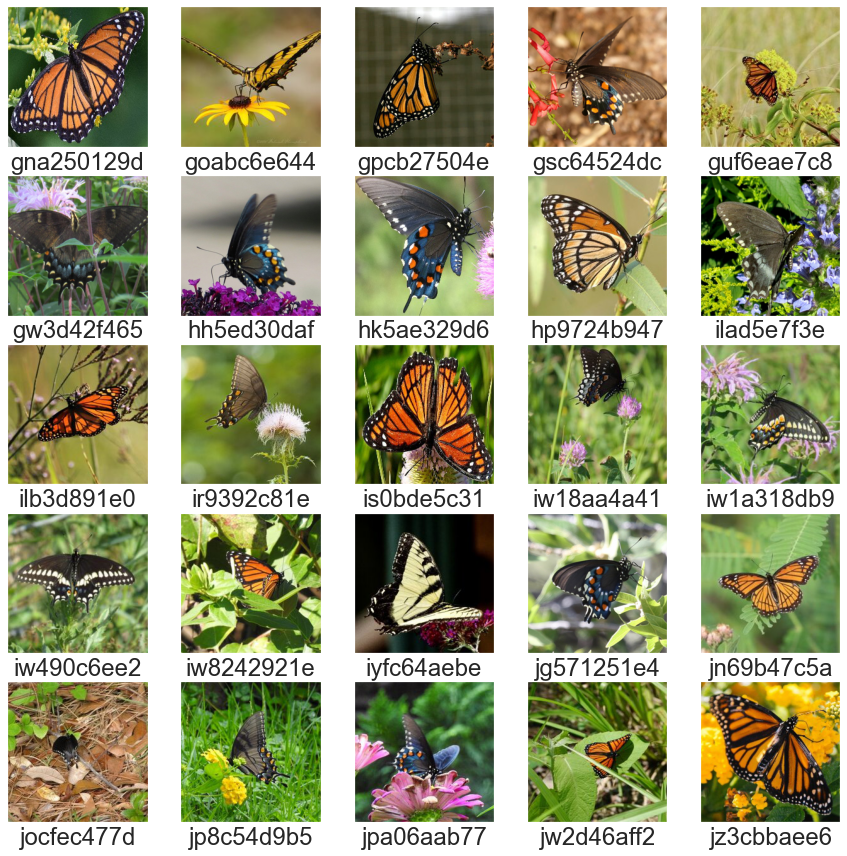

In [46]:

fig, ax = plt.subplots(5, 5, figsize=(15, 15))

maxloop = int(len(test_csv_data)/25)+1

if j < maxloop:
    for i, axi in enumerate(ax.flat):
        k = (j*25) + i

        if k < len(test_csv_data):
            file = os.path.join(test_dir, test_csv_data.image[k]+".jpg")
            image = io.imread(file, as_gray=False)

            axi.grid(None)
            axi.axis('on')

            axi.imshow(image, interpolation_stage='rgb')
            axi.set(xticks=[], yticks=[], xlabel = test_csv_data.image[k])
        else:
            axi.set_visible(False)

    j = j + 1
    plt.show()

### &nbsp;
---
### Explore Submissions
---

### What should a submission look like?

In [47]:
print("Example Submission")
print("------------------")
submit_ds = pd.read_csv(submit_csv)
submit_ds.head()

Example Submission
------------------


,image,name
0,gna250129d,black 0.3
1,goabc6e644,monarch 0.3
2,gpcb27504e,pipevine 0.3
3,gsc64524dc,spicebush 0.3
4,guf6eae7c8,tiger 0.3


### &nbsp;
### That's it. Everything looks good!